In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
#from curlyBrace import curlyBrace
from scipy import stats
from tqdm.notebook import tqdm
import glob
import os
from sklearn import decomposition, preprocessing, manifold
#import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pickle
from sklearn import model_selection
from sklearn import preprocessing, decomposition, linear_model, metrics , feature_selection, model_selection, cross_decomposition, ensemble, tree, manifold, svm, neural_network 
import warnings
import io
from sklearn.exceptions import ConvergenceWarning
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init

import time
from IPython.display import clear_output
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import cm

import multiprocessing

from jupyterthemes import jtplot
from datetime import datetime
import sklearn

torch.manual_seed(42)

In [2]:
np.random.seed(42)
jtplot.reset()
jtplot.reset()

const = 12
SMALL_SIZE = 8 + const  
MEDIUM_SIZE = 10 + const
BIGGER_SIZE = 12 + const

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=20)
np.core.arrayprint._line_width = 1000


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

"""
EMBEDDING_DIM = 512
MAX_SENT_LEN = 50

pe = PositionalEncoding(EMBEDDING_DIM, max_len = MAX_SENT_LEN)
#src, tgt = enc_embedding(src), dec_embedding(tgt)
# (SEQ_LEN, BATCH_SIZE, EMBEDDING_DIM)
tgt = torch.zeros(20, 32, 512)
tgt = pe(tgt)

decoder_layer = nn.TransformerDecoderLayer(d_model=EMBEDDING_DIM, nhead=1, dim_feedforward=256, dropout=0)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)
memory = torch.rand(2, 32, 512)   # encoder out (SEQ_LEN, BATCH_SIZE, EMBEDDING_DIM)
out = transformer_decoder(tgt, memory)
"""
pass

In [3]:
class GraphAttentionLayer(nn.Module):
    """
    https://github.com/Diego999/pyGAT/blob/master/layers.py
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        #self.W = nn.Parameter(torch.empty(size=(2*in_features, out_features)))
        #nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.W = nn.Linear(2*in_features,  #in_features, 
                           out_features)
        nn.init.xavier_uniform_(self.W.weight, gain=1.414)
        
        #self.W_value = nn.Parameter(torch.empty(size=(in_features, out_features)))
        #nn.init.xavier_uniform_(self.W_value.data, gain=1.414)
        
        self.W_value = nn.Linear(in_features, out_features)
        nn.init.xavier_uniform_(self.W_value.weight, gain=1.414)
        
        #self.a = nn.Parameter(torch.empty(size=(out_features+4, 1)))
        #nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        self.a = nn.Linear(out_features+4,
                           1)
        nn.init.xavier_uniform_(self.a.weight, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    #def forward(self, h, adj):
    # adj = batch * n_times, n_nodes, n_nodes, n_features
    def forward(self, h, adj):
        """

        :param h: (batch_zize, number_nodes, in_features)
        :param adj: (batch_size, number_nodes, number_nodes)
        :return: (batch_zize, number_nodes, out_features)
        """
        # batchwise matrix multiplication
        # (batch_zize, number_nodes, in_features) * (in_features, out_features)
        # -> (batch_zize, number_nodes, out_features)
        Wh = h  #torch.matmul(h, self.W)
        Wv = self.leakyrelu(self.W_value(h))  #torch.matmul(h, self.W_value)
        Wv = F.dropout(Wv, self.dropout, training=self.training)

        # (batch_zize, number_nodes, number_nodes, 2 * out_features)
        a_input = self.batch_prepare_attentional_mechanism_input(Wh)  # used to be Wh
        a_input = self.leakyrelu(self.W(a_input))  #self.leakyrelu(torch.matmul(a_input, self.W))
        a_input = torch.cat([a_input, adj], dim=-1)
        a_input = F.dropout(a_input, self.dropout, training=self.training)

        # (batch_zize, number_nodes, number_nodes, 2 * out_features) * (2 * out_features, 1)
        # -> (batch_zize, number_nodes, number_nodes, 1)
        e = self.a(a_input)  #torch.matmul(a_input, self.a)

        # (batch_zize, number_nodes, number_nodes)
        e = self.leakyrelu(e.squeeze(-1))

        # (batch_zize, number_nodes, number_nodes)
        #zero_vec = -9e15 * torch.ones_like(e)

        # (batch_zize, number_nodes, number_nodes)
        #attention = torch.where(adj > 0, e, zero_vec)
        attention = e

        # (batch_zize, number_nodes, number_nodes)
        attention = F.softmax(attention, dim=-1)

        # (batch_zize, number_nodes, number_nodes)
        attention = F.dropout(attention, self.dropout, training=self.training)

        # batched matrix multiplication (batch_zize, number_nodes, out_features)
        h_prime = torch.matmul(attention, Wv)  # same as bmm
    
        if self.concat:
            return h_prime + Wv, attention, Wv  #F.elu(h_prime) + Wv
        else:
            return h_prime + Wv, attention, Wv

    def batch_prepare_attentional_mechanism_input(self, Wh):
        """
        with batch training
        :param Wh: (batch_zize, number_nodes, out_features)
        :return:
        """
        B, M, E = Wh.shape # (batch_zize, number_nodes, out_features)
        Wh_repeated_in_chunks = Wh.repeat_interleave(M, dim=1)  # (B, M*M, E)
        Wh_repeated_alternating = Wh.repeat(1, M, 1)  # (B, M*M, E)
        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=-1)  # (B, M*M,2E)
        return all_combinations_matrix.view(B, M, M, 2 * E)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [4]:
class Transformer_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(Transformer_Decoder, self).__init__()
        self.embedding_dim = nhid * nheads
        self.dropout = dropout
        self.pe = PositionalEncoding(d_model=self.embedding_dim, dropout=0, max_len=25)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=self.embedding_dim, nhead=1, dim_feedforward=self.embedding_dim, dropout=0)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=1)
        self.in_embed = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.out_embed = nn.Linear(self.embedding_dim, nclass)
        self.leakyrelu = nn.LeakyReLU(alpha)
        nn.init.xavier_uniform_(self.in_embed.weight, gain=1.414)
        nn.init.xavier_uniform_(self.out_embed.weight, gain=1.414)
        
    def forward(self, node_embeddings, exp_in, gat_embeddings_tf_in, gat_embeddings, n_frame_pred):
        decoder_memory = gat_embeddings.sum(1).unsqueeze(1).permute((1, 0, 2))
        decoder_memory = decoder_memory.repeat(1, n_frame_pred*22, 1)
        decoder_memory = F.dropout(decoder_memory, self.dropout, training=self.training)
        node_input_t = self.leakyrelu(self.in_embed(gat_embeddings_tf_in)).permute((1, 0, 2))
        node_input_t = self.pe(node_input_t)
        decoder_target = node_input_t  #self.pe(node_input_t.permute((1, 0, 2)))
        decoder_target = F.dropout(decoder_target, self.dropout, training=self.training)
        decoder_out = self.transformer_decoder(decoder_target, decoder_memory)
        decoder_out = F.dropout(decoder_out, self.dropout, training=self.training)
        predictor_out = self.out_embed(decoder_out).permute((1, 0, 2))
        predictor_out = predictor_out[:, -1, :]
        predictor_out = unflatted_batch_dim(predictor_out)
        return predictor_out + exp_in

In [5]:
class GAT_Encoder(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT_Encoder, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
        
    def forward(self, x, exp_in, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        #x = torch.cat([att(x, adj) for att in self.attentions], dim=-1)
        x, attention, node_embeddings = self.attentions[0](x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        return x, attention, node_embeddings

In [6]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout
            
        self.gat_encoder = GAT_Encoder(nfeat, nhid, nclass, dropout, alpha, nheads)
        self.tformer_decoder = Transformer_Decoder(nfeat, nhid, nclass, dropout, alpha, nheads)
        self.norm = nn.LayerNorm(nhid)
        
    def forward(self, x, exp_in, adj, n_frame_pred):
        node_embeddings = x
        gat_embeddings, gat_attn_matrix, gat_node_embeddings = self.gat_encoder(x, exp_in, adj)
        gat_embeddings = self.norm(gat_embeddings)
        gat_embeddings_tf_in = flatten_batch_dim(gat_embeddings).unsqueeze(1).repeat(1, n_frame_pred, 1)
        tformer_predictions = self.tformer_decoder(node_embeddings, exp_in, gat_embeddings_tf_in, gat_embeddings, n_frame_pred)
        return tformer_predictions, gat_embeddings, gat_attn_matrix, gat_node_embeddings

# Data Loading

In [7]:
plays_df = pd.read_csv('./plays.csv')
games_df = pd.read_csv('./games.csv')
players_df = pd.read_csv('./players.csv')
pff_df = pd.read_csv('./pffScoutingData.csv')
snap_data = pickle.load(open('./ts_player_features_game_playid.pickle', 'rb'))
# ts_features, delta_features, r_features, player_features, game, play_id
player_embed, dense_player_embed = pickle.load(open('./player_embed_dense.pickle', 'rb'))


nflid_to_idx = dict()
for i, nflid in enumerate(players_df.nflId.values.flatten()):
    assert nflid not in nflid_to_idx
    nflid_to_idx[nflid] = i

assert i == 1678
nflid_to_idx[0] = 1679

In [8]:
pff_df.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [9]:
edge_features = [np.concatenate((snap_data[i][1], snap_data[i][2]), axis=3) for i in range(len(snap_data))]
edge_features = np.array(edge_features)
edge_features.shape

(7772, 20, 22, 22, 4)

In [10]:
ts_features = np.array([snap_data[i][0] for i in range(len(snap_data))])
ts_features.shape

(7772, 20, 22, 9)

In [11]:
player_roles = np.zeros((len(snap_data), 22))
for i in tqdm(range(len(snap_data))):
    _, _, _, player_features_i, game, play_id = snap_data[i]
    player_roles[i, :] = pff_df[(pff_df.gameId == game) & (pff_df.playId == play_id)].set_index('nflId').reindex(player_features_i).pff_role.isin(['Pass Rush', 'Pass Block']).values.astype(int)
player_roles = np.repeat(player_roles[:, np.newaxis, :], edge_features.shape[1], 1)
player_roles.shape

  0%|          | 0/7772 [00:00<?, ?it/s]

(7772, 20, 22)

In [12]:
#player_embed = dense_player_embed
player_embed = np.concatenate((player_embed, np.zeros((1, player_embed.shape[1]))), axis=0)

#player_features = np.stack([snap_data[idx][1] for idx in train_idxs], axis=2)
player_features = []
for idx in tqdm(range(len(snap_data)), ncols=1000):
    player_features_i = snap_data[idx][3]
    player_features.append(player_embed[[nflid_to_idx[player_id] for player_id in player_features_i], :])
player_features = np.stack(player_features, axis=2).swapaxes(0, 2).swapaxes(1, 2)
#player_features = np.concatenate((player_features,
#                                  np.stack([snap_data[idx][1] for idx in range(len(snap_data))], axis=0)[:, :, 1:]),
#                                 axis=2)
#player_features = np.stack([snap_data[idx][1] for idx in range(len(snap_data))], axis=0)
#player_features = player_features[:, :, 1:]

game_ids = np.stack([snap_data[idx][4] for idx in range(len(snap_data))], axis=0)
play_ids = np.stack([snap_data[idx][5] for idx in range(len(snap_data))], axis=0)

  0%|                                                                                                         …

In [24]:
all_game_ids = np.stack([snap_data[idx][4] for idx in range(len(snap_data))], axis=0)
train_idxs = []
test_idxs = []
valid_idxs = []
for i, game_id in enumerate(tqdm(all_game_ids, ncols=1000)):
    if games_df[games_df.gameId == game_id].week.values.flatten()[0] < 7:
        train_idxs.append(i)
    elif games_df[games_df.gameId == game_id].week.values.flatten()[0] == 7:
        valid_idxs.append(i)
    else:
        test_idxs.append(i)
        
        
#[['pff_hit', 'pff_hurry', 'pff_sack']]

y = []
for i in tqdm(range(len(snap_data)), ncols=1000):
    _, _, _, _, game, play_id = snap_data[i]
    #y_i = int(np.any(pff_df[(pff_df.gameId == game) & (pff_df.playId == play_id)][['pff_hit', 'pff_hurry', 'pff_sack']].values == 1))
    #y_i = np.any(pff_df[(pff_df.gameId == game) & (pff_df.playId == play_id)][['pff_hit', 'pff_hurry', 'pff_sack']].fillna(0).values, axis=0).astype(int).sum()
    y_sack = int(np.any(pff_df[(pff_df.gameId == game) & (pff_df.playId == play_id)][['pff_sack']].fillna(0).values.flatten()))
    y_hurry = int(np.any(pff_df[(pff_df.gameId == game) & (pff_df.playId == play_id)][['pff_hurry']].fillna(0).values.flatten()))
    y.append(y_i)
play_outcomes = np.array(y)

  0%|                                                                                                         …

  0%|                                                                                                         …

In [25]:
pickle.dump((player_features, edge_features, ts_features, player_roles, train_idxs, valid_idxs, test_idxs), open('./ssl_next_frame_ts.pickle', 'wb'), protocol=4)

# Training

In [7]:
player_features, edge_features, ts_features, player_roles, train_idxs, valid_idxs, test_idxs = pickle.load(open('./ssl_next_frame_ts_gpt.pickle', 'rb'))
#player_features = player_features[:100]
#edge_features = edge_features[:100]
#ts_features = ts_features[:100]
#play_roles = player_roles[:100]
#train_idxs = train_idxs[:100]
#valid_idxs = []
#test_idxs = []

In [8]:
# hyper params, input
FP = np.float32

torch_device = torch.device('cuda:0') 
edge_features_gpu = torch.from_numpy(np.nan_to_num(edge_features.astype(FP), nan=0, posinf=0, neginf=0)).to(torch_device)

edges = edge_features_gpu
#node_features = player_features_gpu.unsqueeze(1).repeat(1, edge_features_gpu.size(1), 1, 1)
player_features_cpu = torch.from_numpy(player_features.astype(FP))
ts_features_cpu = torch.from_numpy(ts_features.astype(FP))
node_features = torch.cat([player_features_cpu.unsqueeze(1).repeat(1, edge_features_gpu.size(1), 1, 1), 
                           ts_features_cpu], dim=-1).to(torch_device)

player_roles_batch = player_roles[:, :, :]
player_roles_batch = np.repeat(player_roles_batch[:, :, :, np.newaxis], 2, 3)
player_roles_batch_cpu = player_roles_batch.copy()

print(node_features.size())
print(edges.size())

torch.Size([7772, 20, 22, 1567])
torch.Size([7772, 20, 22, 22, 4])


In [9]:
ts_features_gpu = node_features[:, :, :, [-9, -8]]
#ts_features_gpu = node_features[:, :, :, -4:-2]
ts_features_gpu.size()

torch.Size([7772, 20, 22, 2])

In [10]:
ts_features_gpu[0, :, 0, 0]

tensor([ 1.3756,  1.3021,  1.2195,  1.1369,  1.0359,  0.9166,  0.7789,  0.6045,
         0.3842,  0.1822, -0.0381, -0.2584, -0.4695, -0.6623, -0.8459, -1.0111,
        -1.1764, -1.3416, -1.4977, -1.6354], device='cuda:0')

In [11]:
ts_features_gpu[0, :, 0, 1]

tensor([ 1.3010,  1.3010,  1.2207,  1.1404,  1.0600,  0.9797,  0.7388,  0.4979,
         0.4176,  0.1767,  0.0161, -0.1446, -0.3855, -0.6264, -0.9476, -1.1082,
        -1.2688, -1.2688, -1.4295, -1.6704], device='cuda:0')

In [12]:
#train_idxs = [x for x in train_idxs if x not in [334, 1571, 949]]

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
def flatten_batch_dim(x):
    return x.reshape((-1,) + x.shape[2:])

def unflatted_batch_dim(x):
    return x.reshape((-1, 22, x.shape[1]))

In [13]:
embedding_dim = 512
gat = GAT(nfeat=node_features.size(3), 
          nhid=embedding_dim, 
          nclass=2, 
          dropout=0.1, alpha=0.01, nheads=1)
gat.load_state_dict(torch.load('gat_SSL_trained.pt'))
gat = gat.to(torch_device)

leakyrelu = nn.LeakyReLU()
LR = 1e-4
optimizer = torch.optim.Adam(gat.parameters(), lr=LR, weight_decay=1e-2)
#pe = PositionalEncoding(d_model=embedding_dim, dropout=0, max_len=25)

mse = nn.MSELoss()  #nn.L1Loss()
train_loss_history = []
test_loss_history = []
val_loss_history = []

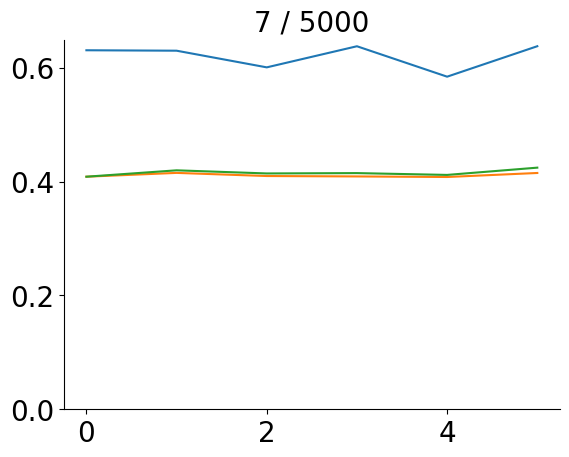

train loss
[0.5668 0.6305 0.6297 0.6005 0.6375 0.5841 0.6376]
valid loss
[0.4026 0.4084 0.4196 0.4142 0.4148 0.4116 0.4243]
test  loss
[0.3994 0.4085 0.4151 0.4096 0.4089 0.4079 0.415 ]


KeyboardInterrupt: 

In [14]:
def display_plot(epoch_i):
    #if epoch_i % print_freq == 0:
    clear_output(wait=True)
    plt.plot(train_loss_history[1:][-print_history:])
    plt.plot(test_loss_history[1:][-print_history:])
    plt.plot(val_loss_history[1:][-print_history:])
    plt.title(f'{epoch_i + 1} / {n_total_epochs}')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(bottom=0)
    #plt.ylim((0, 0.03))
    plt.show()
    print('train loss')
    print(np.round(train_loss_history, 4))
    print('valid loss')
    print(np.round(val_loss_history, 4))
    print('test  loss')
    print(np.round(test_loss_history, 4))


n_total_epochs = 5000
print_freq = 1
print_history = 200
ts_idx_to_input = np.array([0, 4, 9])  #np.arange(0, 10)
batch_size = 64


for epoch_i in tqdm(range(n_total_epochs), ncols=1000):
    batch_losses = []
    for train_batch in chunks(np.random.choice(train_idxs, size=len(train_idxs), replace=False),
                              batch_size):

        optimizer.zero_grad()
        gat.zero_grad()
        
        n_frame_pred = np.random.choice(np.arange(1, 16))   #  [1, 5, 10])
        ts_idx_to_input = np.random.choice(np.arange(20-n_frame_pred), size=8)
        #if n_frame_pred < 5:
        #    ts_idx_to_input = np.random.choice(np.arange(15), size=3)
        #elif n_frame_pred < 10:
        #    ts_idx_to_input = np.random.choice(np.arange(10), size=3)
        #else:
        #    ts_idx_to_input = np.random.choice(np.arange(5), size=3)
        #n_frame_pred = 5
        #ts_idx_to_input = np.array([0, 5, 10])
        
        dat_in = flatten_batch_dim(node_features[train_batch, :, :, :][:, ts_idx_to_input, :, :])
        exp_out = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input+n_frame_pred, :, :])
        exp_in = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input, :, :])
        edges_in = flatten_batch_dim(edges[train_batch, :, :, :, :][:, ts_idx_to_input, :, :, :])

        predictor_out, _, _, _ = gat(dat_in, exp_in, edges_in, n_frame_pred)

        player_roles_batch = torch.from_numpy(player_roles_batch_cpu[train_batch, :, :, :][:, ts_idx_to_input, :, :].astype(np.float32)).to(torch_device)
        #player_roles_batch = player_roles_gpu[train_batch, :, :, :]
        player_roles_batch = (flatten_batch_dim(player_roles_batch) * 0.2) + 1
        loss = mse(predictor_out*player_roles_batch, exp_out*player_roles_batch)
        #loss = mse(predictor_out, exp_out)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss_history.append(np.mean(batch_losses))


    with torch.no_grad():
        n_frame_pred = 5
        ts_idx_to_input = np.array([0, 5, 10])
        
        test_loss = []
        for train_batch in chunks(np.random.choice(test_idxs, size=len(test_idxs), replace=False),
                                  batch_size):
            dat_in = flatten_batch_dim(node_features[train_batch, :, :, :][:, ts_idx_to_input, :, :])
            exp_out = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input+n_frame_pred, :, :])
            exp_in = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input, :, :])
            edges_in = flatten_batch_dim(edges[train_batch, :, :, :, :][:, ts_idx_to_input, :, :, :])
            predictor_out, _, _, _ = gat(dat_in, exp_in, edges_in, n_frame_pred)
            player_roles_batch = torch.from_numpy(player_roles_batch_cpu[train_batch, :, :, :][:, ts_idx_to_input, :, :].astype(np.float32)).to(torch_device)
            #player_roles_batch = player_roles_gpu[train_batch, :, :, :]
            player_roles_batch = (flatten_batch_dim(player_roles_batch) * 0.2) + 1
            loss = mse(predictor_out*player_roles_batch, exp_out*player_roles_batch)
            #loss = mse(predictor_out, exp_out)
            test_loss.append(loss.item())

        val_loss = []
        for train_batch in chunks(np.random.choice(valid_idxs, size=len(valid_idxs), replace=False),
                                  batch_size):
            dat_in = flatten_batch_dim(node_features[train_batch, :, :, :][:, ts_idx_to_input, :, :])
            exp_out = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input+n_frame_pred, :, :])
            exp_in = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input, :, :])
            edges_in = flatten_batch_dim(edges[train_batch, :, :, :, :][:, ts_idx_to_input, :, :, :])
            predictor_out, _, _, _ = gat(dat_in, exp_in, edges_in, n_frame_pred)
            player_roles_batch = torch.from_numpy(player_roles_batch_cpu[train_batch, :, :, :][:, ts_idx_to_input, :, :].astype(np.float32)).to(torch_device)
            #player_roles_batch = player_roles_gpu[train_batch, :, :, :]
            player_roles_batch = (flatten_batch_dim(player_roles_batch) * 0.2) + 1
            loss = mse(predictor_out*player_roles_batch, exp_out*player_roles_batch)
            #loss = mse(predictor_out, exp_out)
            val_loss.append(loss.item())

        test_loss_history.append(np.mean(test_loss))
        val_loss_history.append(np.mean(val_loss))

    #if len(val_loss_history) > print_history:
    #    if np.min(val_loss_history) < (0.95*val_loss_history[-1]):
    #        display_plot(epoch_i)
    #        print('stopping per validation')
    #        break

    display_plot(epoch_i)

In [ ]:
torch.save(gat.cpu().state_dict(), './gat_SSL_trained.pt')

In [ ]:
plt.plot(train_loss_history[1:])
plt.plot(test_loss_history[1:])
plt.plot(val_loss_history[1:])
plt.title(f'{epoch_i + 1} / {n_total_epochs}')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(bottom=0)
#plt.ylim((0, 0.03))
plt.show()

In [21]:
test_loss_history[-1]

0.4066213318487493

In [ ]:
#####################
## end of training ##
#####################

In [21]:
predictor_out.size()

torch.Size([24, 22, 2])

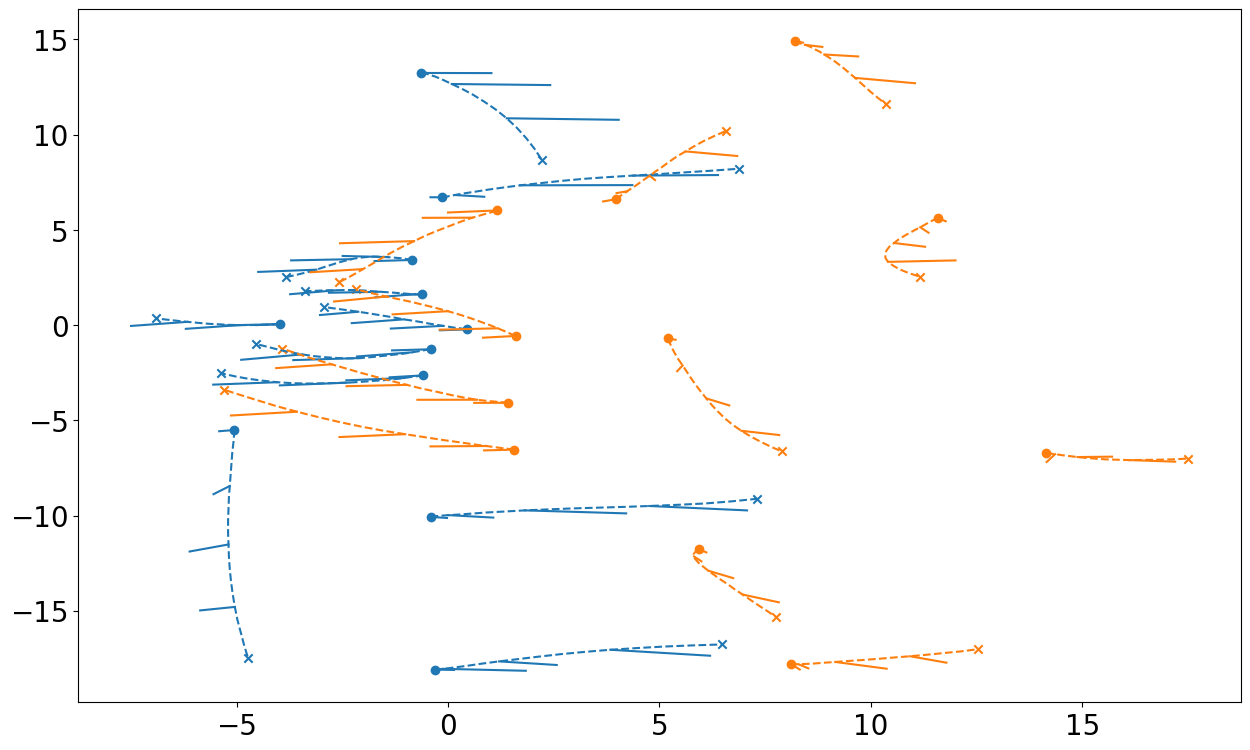

In [16]:
train_batch = np.random.choice(train_idxs, 1)
n_frame_pred = 5
ts_idx_to_input = np.array([0, 5, 10, 15])

with torch.no_grad():
    test_loss = []
    
    dat_in = flatten_batch_dim(node_features[train_batch, :, :, :][:, ts_idx_to_input, :, :])
    exp_in = flatten_batch_dim(ts_features_gpu[train_batch, :, :, :][:, ts_idx_to_input, :, :])
    edges_in = flatten_batch_dim(edges[train_batch, :, :, :, :][:, ts_idx_to_input, :, :, :])

    predictor_out, _, _, _ = gat(dat_in, exp_in, edges_in, n_frame_pred)
    
plt.figure(figsize=(15, 9))
plot_dat = ts_features_gpu[train_batch[0], :, :, :2]
for i in range(plot_dat.size(1)):
    #for j in range(20):
    #    plt.scatter(ts_features_gpu[train_batch[0], j, i, 0].detach().cpu().numpy(),
    #                ts_features_gpu[train_batch[0], j, i, 1].detach().cpu().numpy(), 
    #                c='C0' if i < 11 else 'C1', alpha=1-(j/20))
    
    plt.plot(ts_features_gpu[train_batch[0], :, i, 0].detach().cpu().numpy(),
             ts_features_gpu[train_batch[0], :, i, 1].detach().cpu().numpy(), 
             color='C0' if i < 11 else 'C1', alpha=1, linestyle='--')
    plt.scatter(ts_features_gpu[train_batch[0], 0, i, 0].detach().cpu().numpy(),
             ts_features_gpu[train_batch[0], 0, i, 1].detach().cpu().numpy(), 
             c='C0' if i < 11 else 'C1', alpha=1, marker='o')
    plt.scatter(ts_features_gpu[train_batch[0], -1, i, 0].detach().cpu().numpy(),
             ts_features_gpu[train_batch[0], -1, i, 1].detach().cpu().numpy(), 
             c='C0' if i < 11 else 'C1', alpha=1, marker='x')

    for t in range(predictor_out.size(0)):
        plt.plot([exp_in[t, i, 0].detach().cpu().numpy().flatten()[0], 
                  predictor_out[t, i, 0].detach().cpu().numpy().flatten()[0]],
                 [exp_in[t, i, 1].detach().cpu().numpy().flatten()[0], 
                  predictor_out[t, i, 1].detach().cpu().numpy().flatten()[0]], 
                 c='C0' if i < 11 else 'C1', alpha=1)
    
    
plt.show()

In [18]:
with torch.cuda.amp.autocast():
    dat_in = flatten_batch_dim(node_features[train_batch, 0:1, :, :])

    init_exp_in = ts_features_gpu[train_batch, 0:1, :, :]
    init_edges_in = edges[train_batch, 0:1, :, :, :]
    later_edges_in = torch.zeros((1, 1, 22, 22, 4)).to(torch_device)
    predictor_out = None
    all_preds_out = []
    n_frames_predict = 3
    with torch.no_grad():

        for i in tqdm(range(n_frames_predict)):
            #"""
            if i == 0:
                exp_in = init_exp_in
                edges_in = init_edges_in
            else:
                exp_in = predictor_out.unsqueeze(0)
                for x_i in range(22):
                    for x_j in range(22):
                        idx_counter = 0
                        for x_k in range(predictor_out.size(2)):
                            later_edges_in[0, 0, x_i, x_j, idx_counter] = (exp_in[0, 0, x_i, x_k] - exp_in[0, 0, x_j, x_k])**2
                            idx_counter += 1
                        for x_k in range(predictor_out.size(2)):
                            later_edges_in[0, 0, x_i, x_j, idx_counter] = exp_in[0, 0, x_i, x_k] * exp_in[0, 0, x_j, x_k]
                            idx_counter += 1

                        #later_edges_in[0, x_i, x_j, 0] = (predictor_out[0, x_i, 0] - predictor_out[0, x_j, 0])**2
                        #later_edges_in[0, x_i, x_j, 1] = (predictor_out[0, x_i, 1] - predictor_out[0, x_j, 1])**2
                        #later_edges_in[0, x_i, x_j, 2] = (predictor_out[0, x_i, 0] * predictor_out[0, x_j, 0])
                        #later_edges_in[0, x_i, x_j, 3] = (predictor_out[0, x_i, 1] * predictor_out[0, x_j, 1])
                        edges_in = later_edges_in
            #"""
            #exp_in = ts_features_gpu[train_batch, (i):(i+1), :, :2]
            #edges_in = edges[train_batch, (i):(i+1), :, :, :]

            exp_in = flatten_batch_dim(exp_in)
            edges_in = flatten_batch_dim(edges_in)
            predictor_out = gat(dat_in, exp_in, edges_in, n_frame_pred)
            all_preds_out.append(predictor_out.detach().cpu())

  0%|          | 0/3 [00:00<?, ?it/s]

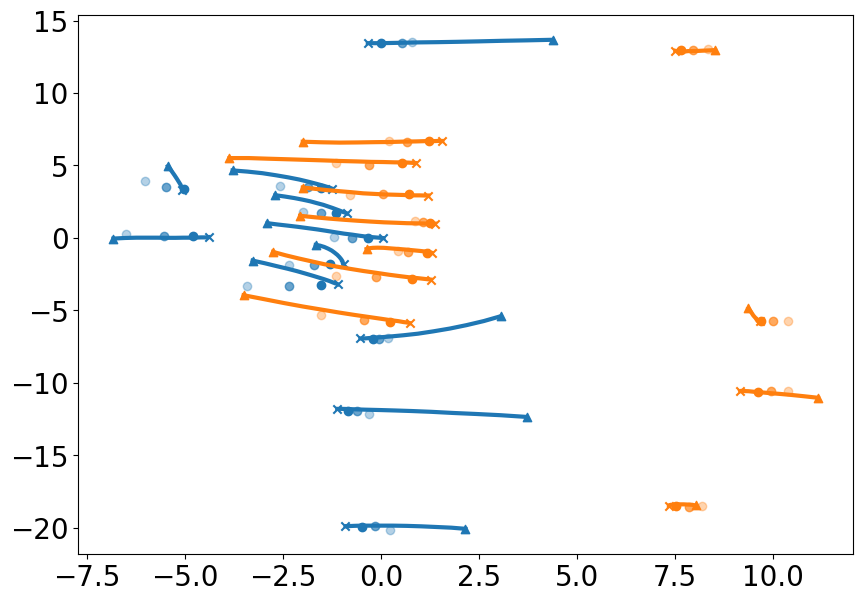

In [21]:
plt.figure(figsize=(10, 7))
plot_dat = ts_features_gpu[train_batch[0], :, :, :2]
for i in range(len(all_preds_out)):
    for j in range(22):
        plt.scatter(all_preds_out[i][0, j, 0].detach().cpu().numpy(),
                    all_preds_out[i][0, j, 1].detach().cpu().numpy(), 
                    c='C0' if j < 11 else 'C1', alpha=1-(i/n_frames_predict))

for j in range(22):
    n_points = 15
    plt.plot(plot_dat[:n_points, j, 0].detach().cpu().numpy(),
             plot_dat[:n_points, j, 1].detach().cpu().numpy(), 
             color='C0' if j < 11 else 'C1', linewidth=3)
    plt.scatter(plot_dat[0, j, 0].detach().cpu().numpy(),
             plot_dat[0, j, 1].detach().cpu().numpy(), 
             c='C0' if j < 11 else 'C1', marker='x')
    plt.scatter(plot_dat[n_points-1, j, 0].detach().cpu().numpy(),
             plot_dat[n_points-1, j, 1].detach().cpu().numpy(), 
             c='C0' if j < 11 else 'C1', marker='^')

    
plt.show()

In [22]:
with torch.cuda.amp.autocast():
    dat_in = flatten_batch_dim(node_features[train_batch, 0:1, :, :])

    init_exp_in = ts_features_gpu[train_batch, 0:1, :, :]
    init_edges_in = edges[train_batch, 0:1, :, :, :]
    later_edges_in = torch.zeros((1, 1, 22, 22, 4)).to(torch_device)
    predictor_out = None
    all_preds_out = []
    n_frames_predict = 3
    players_to_sim = [0]
    players_not_to_sim = [x for x in range(22) if x not in players_to_sim]

    with torch.no_grad():

        for i in tqdm(range(n_frames_predict)):
            #"""
            if i == 0:
                exp_in = init_exp_in  #flatten_batch_dim(init_exp_in)
                edges_in = init_edges_in #flatten_batch_dim(init_edges_in)
            else:
                exp_in_copy = ts_features_gpu[train_batch, (i*n_frame_pred):((i*n_frame_pred)+1), :, :].clone()
                for p_i, p in enumerate(players_to_sim):
                    exp_in_copy[0, 0, p, :] = predictor_out[0, p, :]
                exp_in = exp_in_copy  #predictor_out.unsqueeze(0)
                for x_i in range(22):
                    for x_j in range(22):
                        idx_counter = 0
                        for x_k in range(predictor_out.size(2)):
                            later_edges_in[0, 0, x_i, x_j, idx_counter] = (exp_in[0, x_i, x_k] - exp_in[0, 0, x_j, x_k])**2
                            idx_counter += 1
                        for x_k in range(predictor_out.size(2)):
                            later_edges_in[0, 0, x_i, x_j, idx_counter] = exp_in[0, x_i, x_k] * exp_in[0, 0, x_j, x_k]
                            idx_counter += 1

                        #later_edges_in[0, x_i, x_j, 0] = (predictor_out[0, x_i, 0] - predictor_out[0, x_j, 0])**2
                        #later_edges_in[0, x_i, x_j, 1] = (predictor_out[0, x_i, 1] - predictor_out[0, x_j, 1])**2
                        #later_edges_in[0, x_i, x_j, 2] = (predictor_out[0, x_i, 0] * predictor_out[0, x_j, 0])
                        #later_edges_in[0, x_i, x_j, 3] = (predictor_out[0, x_i, 1] * predictor_out[0, x_j, 1])
                        edges_in = later_edges_in

            #"""
            #exp_in = ts_features_gpu[train_batch, (i):(i+1), :, :2]
            #edges_in = edges[train_batch, (i):(i+1), :, :, :]

            exp_in = flatten_batch_dim(exp_in)
            edges_in = flatten_batch_dim(edges_in)
            predictor_out = gat(dat_in, exp_in, edges_in, n_frame_pred)
            all_preds_out.append(predictor_out.detach().cpu())

  0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: expand(torch.cuda.FloatTensor{[2]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

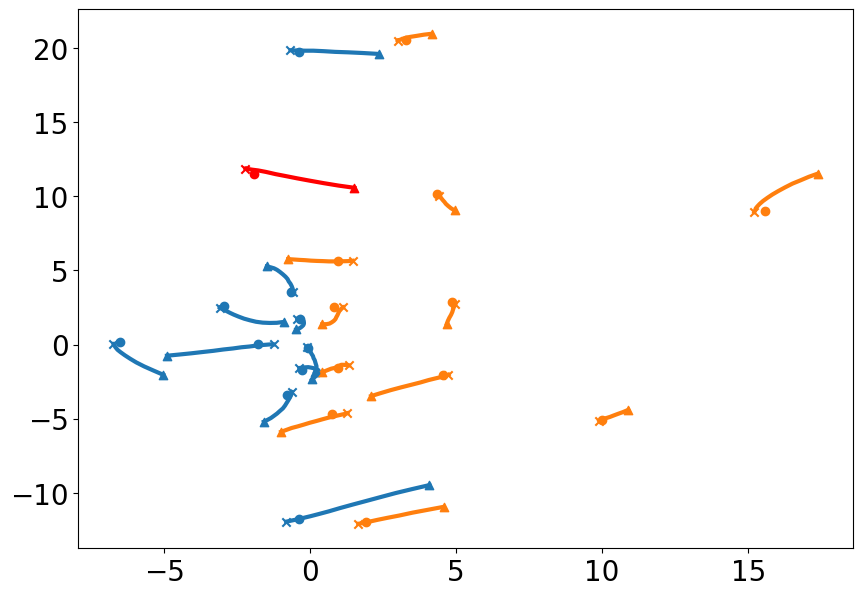

In [22]:
plt.figure(figsize=(10, 7))
plot_dat = ts_features_gpu[train_batch[0], :, :, :2]
for i in range(len(all_preds_out)):
    for j in range(22):
        c = 'C0' if j < 11 else 'C1'
        if j in players_to_sim: c = 'r'
        plt.scatter(all_preds_out[i][0, j, 0].detach().cpu().numpy(),
                    all_preds_out[i][0, j, 1].detach().cpu().numpy(), 
                    c=c, alpha=1-(i/n_frames_predict))

for j in range(22):
    n_points = 15
    c = 'C0' if j < 11 else 'C1'
    if j in players_to_sim: c = 'r'

    plt.plot(plot_dat[:n_points, j, 0].detach().cpu().numpy(),
             plot_dat[:n_points, j, 1].detach().cpu().numpy(), 
             color=c, linewidth=3)
    plt.scatter(plot_dat[0, j, 0].detach().cpu().numpy(),
             plot_dat[0, j, 1].detach().cpu().numpy(), 
             c=c, marker='x')
    plt.scatter(plot_dat[n_points-1, j, 0].detach().cpu().numpy(),
             plot_dat[n_points-1, j, 1].detach().cpu().numpy(), 
             c=c, marker='^')

    
plt.show()